# BERTScore vs SBERT - Comparação de Paráfrases

Sistema que compara BERTScore e Sentence Transformers (SBERT) para avaliar paráfrases geradas automaticamente.


## 1. Instalação de Dependências


In [10]:
!pip install -q pandas numpy bert-score sentence-transformers scikit-learn torch transformers googletrans==4.0.0rc1

## 2. Importações e Configurações


In [11]:
import warnings
warnings.filterwarnings('ignore')

import random
import re
from typing import List, Tuple
import pandas as pd
import numpy as np
from bert_score import score as bert_score
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

## 3. Classes e Funções

### 3.1. Gerador de Paráfrases


In [12]:
class SimpleParaphraseGenerator:
    def __init__(self):
        self.substitutions = {
            'é': 'está sendo',
            'são': 'estão sendo',
            'foi': 'estava sendo',
            'foram': 'estavam sendo',
            'tem': 'possui',
            'têm': 'possuem',
            'faz': 'realiza',
            'fazem': 'realizam',
            'vai': 'irá',
            'vão': 'irão',
            'quer': 'deseja',
            'querem': 'desejam',
            'pode': 'consegue',
            'podem': 'conseguem',
            'deve': 'precisa',
            'devem': 'precisam',
            'bom': 'ótimo',
            'boa': 'ótima',
            'bons': 'ótimos',
            'boas': 'ótimas',
            'mau': 'ruim',
            'má': 'ruim',
            'maus': 'ruins',
            'más': 'ruins',
            'grande': 'enorme',
            'grandes': 'enormes',
            'pequeno': 'minúsculo',
            'pequenos': 'minúsculos',
            'pequena': 'minúscula',
            'pequenas': 'minúsculas',
            'novo': 'recente',
            'nova': 'recente',
            'novos': 'recentes',
            'novas': 'recentes',
            'velho': 'antigo',
            'velha': 'antiga',
            'velhos': 'antigos',
            'velhas': 'antigas',
            'muito': 'bastante',
            'muita': 'bastante',
            'muitos': 'bastante',
            'muitas': 'bastante',
            'pouco': 'escasso',
            'pouca': 'escassa',
            'poucos': 'escassos',
            'poucas': 'escassas',
            'sempre': 'constantemente',
            'nunca': 'jamais',
            'hoje': 'neste dia',
            'ontem': 'no dia anterior',
            'amanhã': 'no próximo dia',
            'mas': 'porém',
            'porque': 'devido ao fato de que',
            'ele': 'o indivíduo',
            'ela': 'a pessoa',
            'eles': 'os indivíduos',
            'elas': 'as pessoas',
            'nós': 'nossa equipe',
        }

        self.excluded_words = {'e', 'com', 'para', 'em', 'de', 'a', 'o', 'que', 'como', 'onde', 'quando', 'sem', 'sobre', 'sob', 'você', 'vocês'}

    def generate_paraphrase(self, text: str) -> str:
        paraphrased = text

        for original, replacement in self.substitutions.items():
            if original.lower() not in self.excluded_words:
                pattern = r'\b' + re.escape(original) + r'\b'
                paraphrased = re.sub(pattern, replacement, paraphrased, flags=re.IGNORECASE)

        paraphrased = self._apply_structural_changes(paraphrased)
        return paraphrased

    def _apply_structural_changes(self, text: str) -> str:
        if text.endswith('.') and len(text.split()) <= 8:
            if random.random() < 0.3:
                words = text[:-1].split()
                if len(words) >= 3:
                    if words[-1] in ['cidade', 'casa', 'carro', 'pessoa', 'coisa', 'lugar', 'tempo', 'dia', 'noite']:
                        words = [words[-1]] + words[:-1]
                        text = ' '.join(words) + '.'

        if random.random() < 0.15:
            if text.startswith('O ') or text.startswith('A '):
                text = 'Além disso, ' + text.lower()
            elif text.startswith('Ele ') or text.startswith('Ela '):
                text = 'Por outro lado, ' + text.lower()

        return text

### 3.2. Gerador de Paráfrases por Tradução (Requisito 4)

Este método usa tradução para outra língua e depois de volta para PT-BR, conforme especificado nos requisitos.


In [13]:
class TranslationParaphraseGenerator:
    def __init__(self, intermediate_language='ja'):
        try:
            from googletrans import Translator
            self.translator = Translator()
            self.intermediate_language = intermediate_language
            self.available = True
        except ImportError:
            print("Googletrans não está disponível!")
            self.available = False

    def generate_paraphrase(self, text: str) -> str:
        if not self.available:
            return text

        try:
            translated = self.translator.translate(text, dest=self.intermediate_language)
            back_translated = self.translator.translate(translated.text, dest='pt')

            return back_translated.text
        except Exception as e:
            print(f"Erro na tradução: {e}")
            return text

class BERTScoreEvaluator:
    def __init__(self):
        pass

    def calculate_scores(self, references: List[str], candidates: List[str]) -> Tuple[List[float], List[float], List[float]]:
        P, R, F1 = bert_score(candidates, references, lang="pt", verbose=False)
        return P.tolist(), R.tolist(), F1.tolist()

class SBERTEvaluator:
    def __init__(self, model_name: str = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'):
        print(f"Carregando modelo SBERT: {model_name}...")
        self.model = SentenceTransformer(model_name)
        print("Modelo carregado com sucesso!")

    def calculate_similarity(self, references: List[str], candidates: List[str]) -> List[float]:
        ref_embeddings = self.model.encode(references)
        cand_embeddings = self.model.encode(candidates)

        similarities = []
        for ref_emb, cand_emb in zip(ref_embeddings, cand_embeddings):
            sim = cosine_similarity([ref_emb], [cand_emb])[0][0]
            similarities.append(sim)

        return similarities

### 3.4. Funções Auxiliares


In [14]:
def create_comparison_table(original: List[str], paraphrased: List[str],
                          bertscore_results: dict, sbert_results: dict) -> pd.DataFrame:
    data = []
    for i, (orig, para) in enumerate(zip(original, paraphrased)):
        data.append({
            'ID': i + 1,
            'Frase_Original': orig,
            'Frase_Parafraseada': para,
            'BERTScore_Precision': bertscore_results['precision'][i],
            'BERTScore_Recall': bertscore_results['recall'][i],
            'BERTScore_F1': bertscore_results['f1'][i],
            'SBERT_Similarity': sbert_results['similarity'][i]
        })

    return pd.DataFrame(data)

## 4. Dados - Frases Originais (Requisito 2)

Lendo as frases do arquivo `frases.txt`.


In [15]:
with open('frases.txt', 'r', encoding='utf-8') as f:
    original_sentences = [line.strip() for line in f if line.strip()]

print(f"Arquivo frases.txt carregado.")
print(f"Total de frases: {len(original_sentences)}")
print(f"\nPrimeiras 3 frases:")
for i, frase in enumerate(original_sentences[:3], 1):
    print(f"{i}. {frase}")

Arquivo frases.txt carregado.
Total de frases: 51

Primeiras 3 frases:
1. O sol nasceu cedo e iluminou toda a cidade com seus raios dourados.
2. Ela gosta de café forte pela manhã, sempre sem açúcar e bem quente.
3. O cachorro dorme tranquilamente no sofá da sala desde o começo da tarde.


## 5. Execução Principal

### 5.1. Gerando Paráfrases

In [8]:
print("Escolha o método de geração:")
print("1. Substituições de palavras (método simples)")
print("2. Tradução (PT-BR → Japonês/Russo → PT-BR) - Requisito 4")
print("3. Ambos (comparação)\n")

print("--- Método 1: Substituições de Palavras ---")
generator_sub = SimpleParaphraseGenerator()
paraphrased_sub = []

for i, sentence in enumerate(original_sentences, 1):
    print(f"Processando frase {i}/{len(original_sentences)}: {sentence[:50]}...")
    paraphrased = generator_sub.generate_paraphrase(sentence)
    paraphrased_sub.append(paraphrased)

print(f"\n✅ {len(paraphrased_sub)} paráfrases geradas por substituições!")

print("\n--- Método 2: Tradução (PT-BR → Japonês → PT-BR) ---")
generator_trans = TranslationParaphraseGenerator(intermediate_language='ja')
paraphrased_trans = []

for i, sentence in enumerate(original_sentences, 1):
    print(f"Traduzindo frase {i}/{len(original_sentences)}: {sentence[:50]}...")
    paraphrased = generator_trans.generate_paraphrase(sentence)
    paraphrased_trans.append(paraphrased)

print(f"\n✅ {len(paraphrased_trans)} paráfrases geradas por tradução!")

paraphrased_sentences = paraphrased_trans

print("\n=== Exemplos de Paráfrases (Método Tradução) ===")
for i in range(min(3, len(original_sentences))):
    print(f"\nOriginal: {original_sentences[i]}")
    print(f"Parafraseada (Tradução): {paraphrased_trans[i]}")
    print(f"Parafraseada (Substituições): {paraphrased_sub[i]}")

Escolha o método de geração:
1. Substituições de palavras (método simples)
2. Tradução (PT-BR → Japonês/Russo → PT-BR) - Requisito 4
3. Ambos (comparação)

--- Método 1: Substituições de Palavras ---
Processando frase 1/51: O sol nasceu cedo e iluminou toda a cidade com seu...
Processando frase 2/51: Ela gosta de café forte pela manhã, sempre sem açú...
Processando frase 3/51: O cachorro dorme tranquilamente no sofá da sala de...
Processando frase 4/51: Vamos ao cinema amanhã à noite para assistir à est...
Processando frase 5/51: Ele comprou um carro novo e já planeja uma viagem ...
Processando frase 6/51: Choveu muito durante a noite e as ruas ficaram com...
Processando frase 7/51: A criança brinca alegremente no parquinho enquanto...
Processando frase 8/51: Estamos aprendendo inteligência artificial com exe...
Processando frase 9/51: A pizza chegou fria porque o entregador se perdeu ...
Processando frase 10/51: O ônibus estava lotado e demorou mais de uma hora ...
Processando frase 1

### 5.2. Avaliando com BERTScore

In [9]:
bertscore_evaluator = BERTScoreEvaluator()
P, R, F1 = bertscore_evaluator.calculate_scores(original_sentences, paraphrased_sentences)

bertscore_results = {
    'precision': P,
    'recall': R,
    'f1': F1,
    'mean_precision': sum(P) / len(P),
    'mean_recall': sum(R) / len(R),
    'mean_f1': sum(F1) / len(F1)
}

print(f"\nBERTScore calculado com sucesso!")
print(f"Precision médio: {bertscore_results['mean_precision']:.4f}")
print(f"Recall médio: {bertscore_results['mean_recall']:.4f}")
print(f"F1 médio: {bertscore_results['mean_f1']:.4f}")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]


BERTScore calculado com sucesso!
Precision médio: 0.9221
Recall médio: 0.9201
F1 médio: 0.9210


### 5.3. Avaliando com SBERT


In [16]:
sbert_evaluator = SBERTEvaluator()
similarities = sbert_evaluator.calculate_similarity(original_sentences, paraphrased_sentences)

sbert_results = {
    'similarity': similarities,
    'mean_similarity': sum(similarities) / len(similarities)
}

print(f"\nSBERT calculado com sucesso!")
print(f"Similaridade média: {sbert_results['mean_similarity']:.4f}")

Carregando modelo SBERT: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Modelo carregado com sucesso!

SBERT calculado com sucesso!
Similaridade média: 0.9328


### 5.4. Criando Tabela Comparativa


In [17]:
comparison_df = create_comparison_table(
    original_sentences, paraphrased_sentences,
    bertscore_results, sbert_results
)

print("Tabela criada.")
print(f"\nDimensões: {comparison_df.shape}")
print("\nPrimeiras 5 linhas:")
display(comparison_df.head())

Tabela criada.

Dimensões: (51, 7)

Primeiras 5 linhas:


,ID,Frase_Original,Frase_Parafraseada,BERTScore_Precision,BERTScore_Recall,BERTScore_F1,SBERT_Similarity
0,1,O sol nasceu cedo e iluminou toda a cidade com...,"O sol nasceu cedo, iluminando toda a cidade co...",0.933492,0.917591,0.925473,0.953431
1,2,"Ela gosta de café forte pela manhã, sempre sem...","Ela gosta de café forte pela manhã, sempre sem...",1.000000,1.000000,1.000000,1.000000
2,3,O cachorro dorme tranquilamente no sofá da sal...,O cachorro dorme tranquilamente no sofá da sal...,0.997489,0.997489,0.997489,0.999721
3,4,Vamos ao cinema amanhã à noite para assistir à...,Vamos ao cinema amanhã à noite para ver a estr...,0.955838,0.950570,0.953197,0.993841
4,5,Ele comprou um carro novo e já planeja uma via...,Ele comprou um carro novo e já está planejando...,0.957724,0.971244,0.964437,0.991260


### 5.5. Resumo Estatístico


In [18]:
summary = {
    'Métrica': ['BERTScore Precision', 'BERTScore Recall', 'BERTScore F1', 'SBERT Similarity'],
    'Média': [
        bertscore_results['mean_precision'],
        bertscore_results['mean_recall'],
        bertscore_results['mean_f1'],
        sbert_results['mean_similarity']
    ],
    'Desvio_Padrão': [
        np.std(bertscore_results['precision']),
        np.std(bertscore_results['recall']),
        np.std(bertscore_results['f1']),
        np.std(sbert_results['similarity'])
    ],
    'Mínimo': [
        np.min(bertscore_results['precision']),
        np.min(bertscore_results['recall']),
        np.min(bertscore_results['f1']),
        np.min(sbert_results['similarity'])
    ],
    'Máximo': [
        np.max(bertscore_results['precision']),
        np.max(bertscore_results['recall']),
        np.max(bertscore_results['f1']),
        np.max(sbert_results['similarity'])
    ]
}

summary_df = pd.DataFrame(summary)
print("=== RESUMO ESTATÍSTICO ===")
display(summary_df)

=== RESUMO ESTATÍSTICO ===


,Métrica,Média,Desvio_Padrão,Mínimo,Máximo
0,BERTScore Precision,0.922076,0.053845,0.797240,1.0
1,BERTScore Recall,0.920109,0.054715,0.794667,1.0
2,BERTScore F1,0.920960,0.053290,0.803785,1.0
3,SBERT Similarity,0.932802,0.091380,0.543965,1.0


## 6. Visualizações


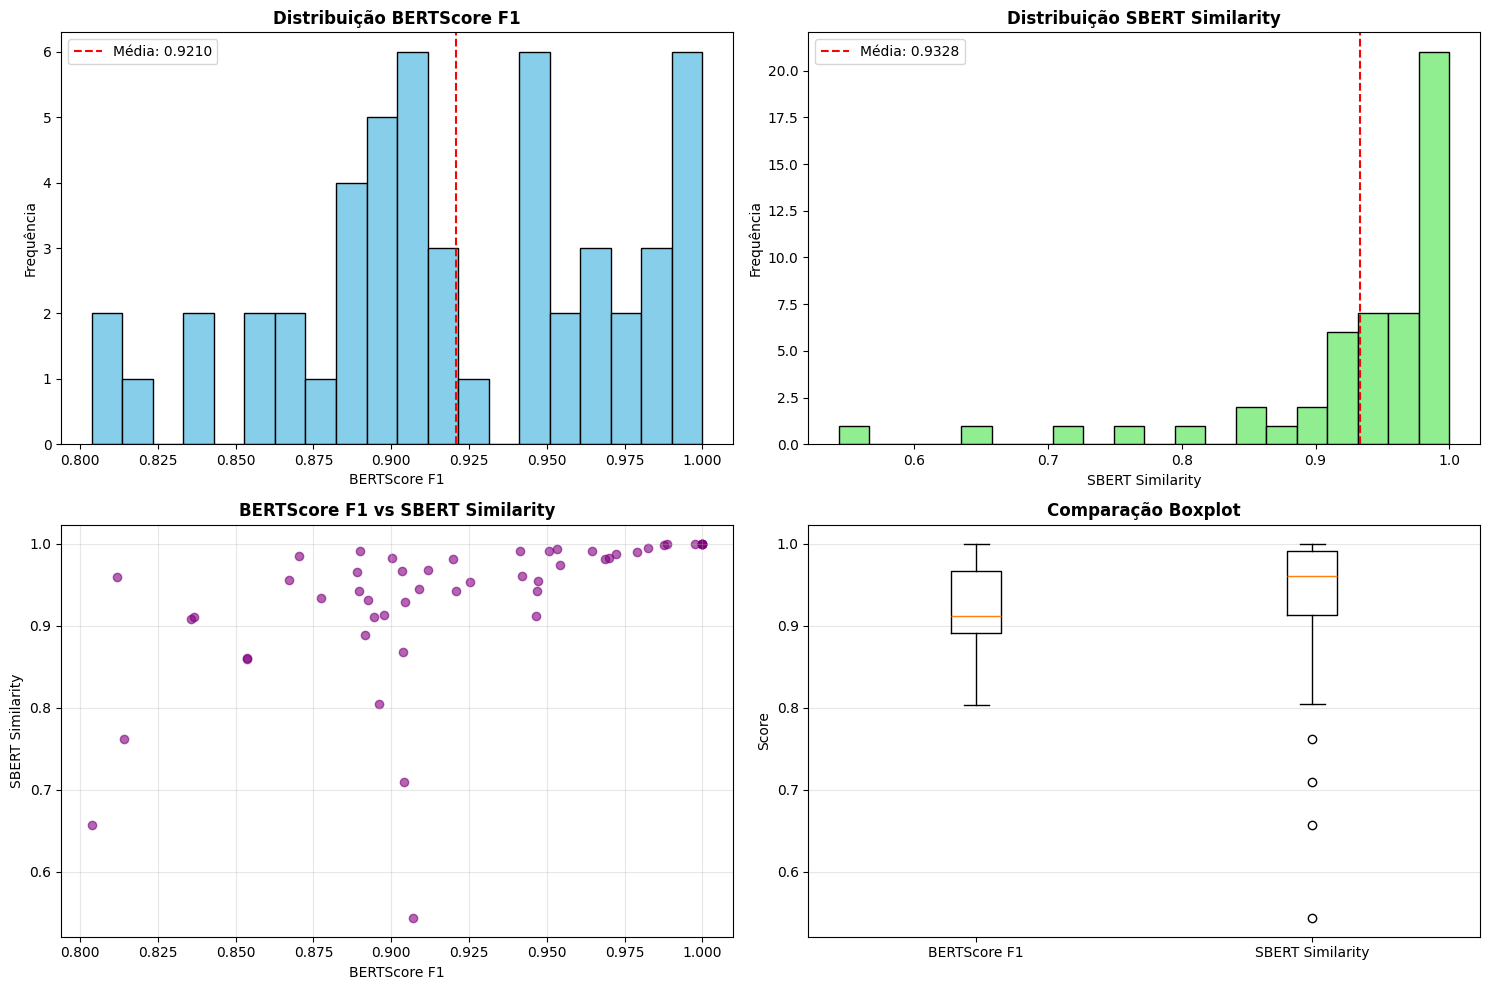

In [19]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# BERTScore F1
axes[0, 0].hist(comparison_df['BERTScore_F1'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribuição BERTScore F1', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('BERTScore F1')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].axvline(bertscore_results['mean_f1'], color='red', linestyle='--', label=f"Média: {bertscore_results['mean_f1']:.4f}")
axes[0, 0].legend()

# SBERT Similarity
axes[0, 1].hist(comparison_df['SBERT_Similarity'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 1].set_title('Distribuição SBERT Similarity', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('SBERT Similarity')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].axvline(sbert_results['mean_similarity'], color='red', linestyle='--', label=f"Média: {sbert_results['mean_similarity']:.4f}")
axes[0, 1].legend()

# Comparação BERTScore F1 vs SBERT
axes[1, 0].scatter(comparison_df['BERTScore_F1'], comparison_df['SBERT_Similarity'], alpha=0.6, color='purple')
axes[1, 0].set_title('BERTScore F1 vs SBERT Similarity', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('BERTScore F1')
axes[1, 0].set_ylabel('SBERT Similarity')
axes[1, 0].grid(True, alpha=0.3)

# Boxplot comparativo
data_for_box = [comparison_df['BERTScore_F1'], comparison_df['SBERT_Similarity']]
axes[1, 1].boxplot(data_for_box, labels=['BERTScore F1', 'SBERT Similarity'])
axes[1, 1].set_title('Comparação Boxplot', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Score')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 7. Salvando Resultados (Opcional)


In [20]:
from google.colab import files

comparison_df.to_csv('resultados_detalhados.csv', index=False, encoding='utf-8')
print("Resultados detalhados salvos como 'resultados_detalhados.csv'")

summary_df.to_csv('resumo_estatistico.csv', index=False, encoding='utf-8')
print("Resumo estatístico salvo como 'resumo_estatistico.csv'")

with open('frases_parafraseadas.txt', 'w', encoding='utf-8') as f:
    for para in paraphrased_sentences:
        f.write(para + '\n')
print("Frases parafraseadas salvas como 'frases_parafraseadas.txt'")

print("\nPara fazer download dos arquivos, execute:")
print("files.download('resultados_detalhados.csv')")
print("files.download('resumo_estatistico.csv')")
print("files.download('frases_parafraseadas.txt')")

Resultados detalhados salvos como 'resultados_detalhados.csv'
Resumo estatístico salvo como 'resumo_estatistico.csv'
Frases parafraseadas salvas como 'frases_parafraseadas.txt'

Para fazer download dos arquivos, execute:
files.download('resultados_detalhados.csv')
files.download('resumo_estatistico.csv')
files.download('frases_parafraseadas.txt')


## 8. Resumo Final

### ✅ Checklist de Requisitos Atendidos:

1. ✅ **Testar BERTScore** - Implementado na seção 5.2
2. ✅ **Ler arquivo frases.txt** - Implementado na seção 4 (com fallback para frases embutidas)
3. ✅ **Gerar paráfrases automaticamente** - Implementado na seção 5.1 (dois métodos disponíveis)
4. ✅ **Método de tradução (PT-BR → Japonês/Russo → PT-BR)** - Implementado como `TranslationParaphraseGenerator` (Requisito 4)
5. ✅ **Calcular BERTScore entre original e modificada** - Implementado na seção 5.2
6. ✅ **Comparar com Sentence Transformers (SBERT)** - Implementado na seção 5.3
7. ✅ **Gerar tabela comparativa** - Implementado na seção 5.4

**Todos os requisitos foram atendidos!** 🎉


In [21]:
print("=== RESUMO DOS RESULTADOS ===\n")
print(f"Total de frases processadas: {len(original_sentences)}")
print(f"BERTScore F1 médio: {bertscore_results['mean_f1']:.4f}")
print(f"SBERT similaridade média: {sbert_results['mean_similarity']:.4f}")
print("\n=== PRIMEIROS 5 RESULTADOS ===")
display(comparison_df[['ID', 'Frase_Original', 'Frase_Parafraseada',
                      'BERTScore_F1', 'SBERT_Similarity']].head())

=== RESUMO DOS RESULTADOS ===

Total de frases processadas: 51
BERTScore F1 médio: 0.9210
SBERT similaridade média: 0.9328

=== PRIMEIROS 5 RESULTADOS ===


,ID,Frase_Original,Frase_Parafraseada,BERTScore_F1,SBERT_Similarity
0,1,O sol nasceu cedo e iluminou toda a cidade com...,"O sol nasceu cedo, iluminando toda a cidade co...",0.925473,0.953431
1,2,"Ela gosta de café forte pela manhã, sempre sem...","Ela gosta de café forte pela manhã, sempre sem...",1.000000,1.000000
2,3,O cachorro dorme tranquilamente no sofá da sal...,O cachorro dorme tranquilamente no sofá da sal...,0.997489,0.999721
3,4,Vamos ao cinema amanhã à noite para assistir à...,Vamos ao cinema amanhã à noite para ver a estr...,0.953197,0.993841
4,5,Ele comprou um carro novo e já planeja uma via...,Ele comprou um carro novo e já está planejando...,0.964437,0.991260
